# Profiling and Analysis Questions


Clustering
https://web.ist.utl.pt/rmch/dash/guides/Clustering%20in%20Python.html


- what are the top aisle purchase clusters?
- what are the most common timeframe order time clusters (order_dow, order_hour_of_day,days_since_prior_order and weeks_since_prior_order) ?

PCA Resources
- https://www.kaggle.com/code/asindico/customer-segments-with-pca
- https://www.datacamp.com/tutorial/principal-component-analysis-in-python
- https://www.youtube.com/watch?v=8klqIM9UvAc
- https://www.youtube.com/watch?v=FD4DeN81ODY
- https://www.youtube.com/watch?v=HMOI_lkzW08

Clustering resources
- https://github.com/jrkreiger/instacart-analysis/blob/master/instacart-analysis.ipynb
- https://medium.com/towards-data-science/customer-segmentation-using-the-instacart-dataset-17e24be9c0fe


Other resources
- https://www.kaggle.com/code/sudalairajkumar/simple-exploration-notebook-instacart

# NOTAS PROF
- DETETAR E EXCLUIR OUTLIERS DOS CLUSTERS PEQUENOS 
- ADICIONAR DENDROGRAMA DOS CLUSTERS 
- EXPERIMENTAR DBSCAN
- ADICIONAR E VALIDAR CENTROIDES

# File and libraries

In [1]:
import pandas as pd
import numpy as np


filepath=r'data\instacart_pre_proc.csv'

file_tag = "Instacart Market Basket"


## DSLabs

In [2]:
%run "scripts/dslabs_functions.py"

# data functions

In [3]:
%run "scripts/data_functions.py"

data_functions lodaded


# Load

In [4]:
test_data=True
# test_data=False


# Define the sampling function
def sample_user_orders(data, fraction=0.1):
    # Get unique user_ids and order_ids
    unique_user_orders = data[['user_id', 'order_id']].drop_duplicates()
    sampled_user_orders = unique_user_orders.sample(frac=fraction)
    
    # Filter the dataset to include only the sampled users and orders
    sampled_data = data[data[['user_id', 'order_id']].apply(tuple, axis=1).isin(sampled_user_orders.apply(tuple, axis=1))]
    return sampled_data



if test_data==True:

    # Apply the sampling to each group 0.5%
    sample=0.2

    # data=pd.read_csv(filepath)
    # data = sample_user_orders(data, fraction=sample)

    users_df=pd.read_csv(r'data\instacart_user_pre_proc.csv')
    users_df=users_df.sample(frac=sample)



else:
    # Apply the sampling to each group 1%   
    sample=0.1


    # data=pd.read_csv(filepath)

    # data = sample_user_orders(data, fraction=sample)

    users_df=pd.read_csv(r'data\instacart_user_pre_proc.csv')
    users_df=users_df.sample(frac=sample)



# data=enrich_instacart_df(data)



users_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33693 entries, 159687 to 121765
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  33693 non-null  int64  
 1   total_orders             33693 non-null  int64  
 2   mean_num_products        33693 non-null  float64
 3   mean_lag_between_orders  31833 non-null  float64
 4   mean_reorder_rate        33693 non-null  float64
 5   mean_weekend_order       33693 non-null  float64
 6   mean_order_dow           33693 non-null  float64
 7   median_order_hour        33693 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 2.3 MB


## variable type definition

In [5]:
from pandas import Series, to_numeric, to_datetime


id_cols=['order_id', 'product_id', 'user_id','aisle_id','department_id']

# data=data.drop(columns=id_cols, axis=1)


def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": [], "id": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        elif c in id_cols:
            variable_types["id"].append(c)
        else:
            try:
                to_numeric(df[c], errors="raise")
                variable_types["numeric"].append(c)
            except ValueError:
                try:
                    df[c] = to_datetime(df[c], errors="raise")
                    variable_types["date"].append(c)
                except ValueError:
                    variable_types["symbolic"].append(c)

    return variable_types


variable_types: dict[str, list] = get_variable_types(users_df)
print(variable_types)


{'numeric': ['total_orders', 'mean_num_products', 'mean_lag_between_orders', 'mean_reorder_rate', 'mean_weekend_order', 'mean_order_dow', 'median_order_hour'], 'binary': [], 'date': [], 'symbolic': [], 'id': ['user_id']}


# Cluster Data Prep

## drop nulls

- this will drop all first buying orders from the dataframe

In [6]:
# drop any null values
# data=data.dropna()

users_df=users_df.dropna()

## Drop outliers

In [7]:
numeric_vars = variable_types["numeric"]

summary5: DataFrame = users_df[numeric_vars].describe(include="all")
summary5

,total_orders,mean_num_products,mean_lag_between_orders,mean_reorder_rate,mean_weekend_order,mean_order_dow,median_order_hour
count,31833.000000,31833.000000,31833.000000,31833.000000,31833.000000,31833.000000,31833.000000
mean,15.827852,11.223020,14.342137,0.503425,0.264206,2.752676,13.533267
std,17.099085,7.169118,8.579823,0.262320,0.326244,1.536115,3.675559
min,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,6.000000,7.157895,0.307692,0.000000,1.676471,11.000000
50%,9.000000,10.000000,12.217391,0.500000,0.127660,2.750000,13.000000
75%,20.000000,15.000000,20.476190,0.705882,0.450000,3.837209,16.000000
max,99.000000,80.643192,30.000000,1.000000,1.000000,6.000000,23.000000


In [ ]:

def drop_numeric_outliers(df, summary, numeric_vars, factor=1.5):
	for var in numeric_vars:
		if var in summary.columns:
			std = summary[var]['std']
			mean = summary[var]['mean']
			lower_bound = mean - factor * std
			upper_bound = mean + factor * std
			df = df[(df[var] >= lower_bound) & (df[var] <= upper_bound)]
	return df


numeric_vars = variable_types["numeric"]
users_df=drop_numeric_outliers(users_df, summary5, numeric_vars)


users_df

,user_id,total_orders,mean_num_products,mean_lag_between_orders,mean_reorder_rate,mean_weekend_order,mean_order_dow,median_order_hour
45500,55670,7,12.000000,12.500000,0.458333,0.500000,4.500000,19.0
30292,37052,28,19.250000,10.119048,0.720238,0.583333,4.089286,10.0
163471,200033,9,14.365854,14.902439,0.439024,0.268293,2.951220,10.0
118987,145447,9,8.000000,2.000000,0.625000,0.000000,3.000000,11.0
30077,36785,28,9.480000,21.600000,0.640000,0.400000,3.920000,14.0
...,...,...,...,...,...,...,...,...
134154,164138,2,13.000000,6.000000,0.153846,0.000000,1.000000,17.0
94762,115863,21,14.021277,7.404255,0.638298,0.723404,4.787234,12.0
69538,84943,9,11.666667,14.000000,0.523810,0.333333,2.000000,14.0
94534,115590,34,13.622642,8.084906,0.707547,0.169811,1.971698,15.0


### New Outlier visualization

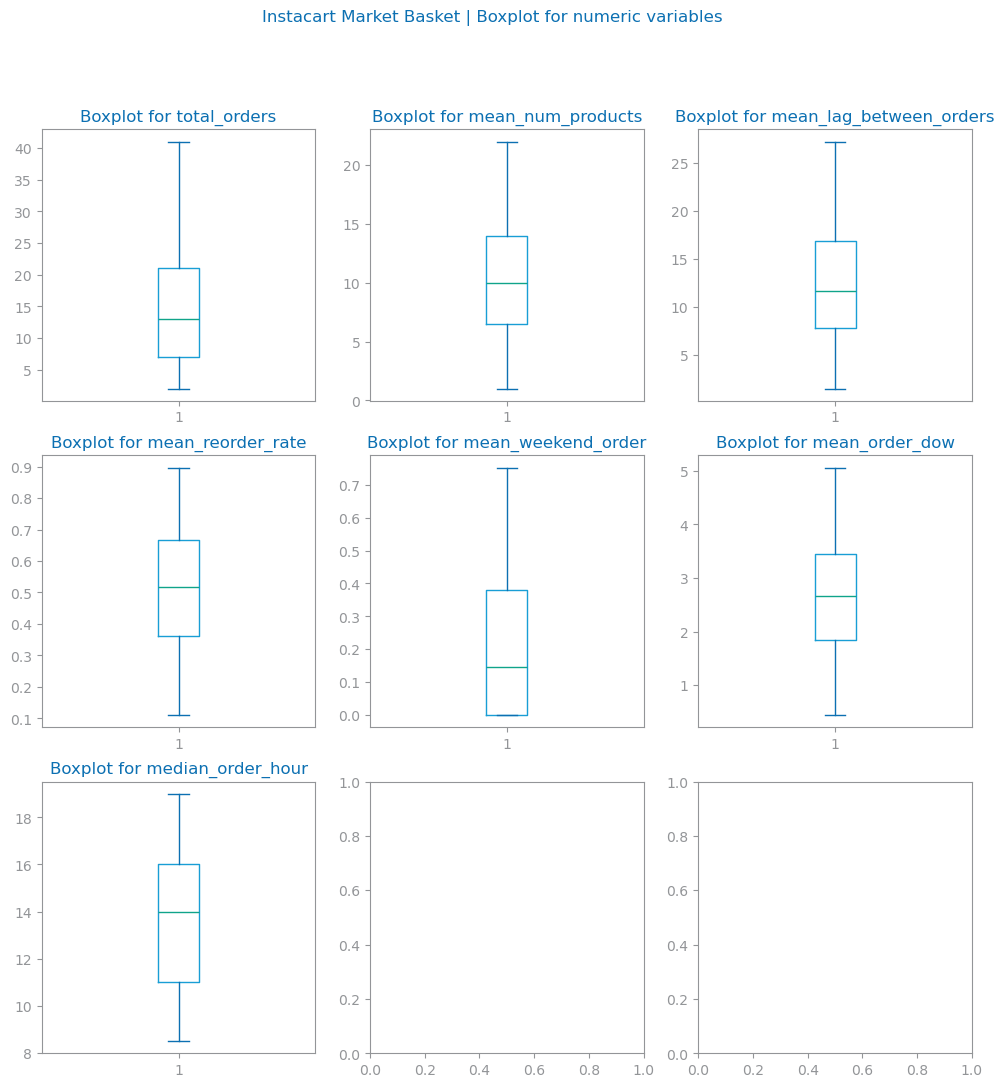

In [9]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric_vars:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric_vars))
    fig: Figure
    axs: ndarray
    title: f'{file_tag} Boxplot for numeric variables'
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    
    fig.suptitle(f'{file_tag} | Boxplot for numeric variables')

    
    i, j = 0, 0
    for n in range(len(numeric_vars)):
        axs[i, j].set_title("Boxplot for %s" % numeric_vars[n])
        axs[i, j].boxplot(users_df[numeric_vars[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

# User Order Behaviour Clustering
- What are cart clusters that are more "refill" vs clusters where we have more "one shot order"?

## User Order feature selection and scaling

In [10]:

from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
reorder_numeric_features = users_df[numeric_vars]

# Normalize the data
scaler = StandardScaler()
reorder_numeric_features_scaled = scaler.fit_transform(reorder_numeric_features)


# User Order Studies

## User Order Dendogram

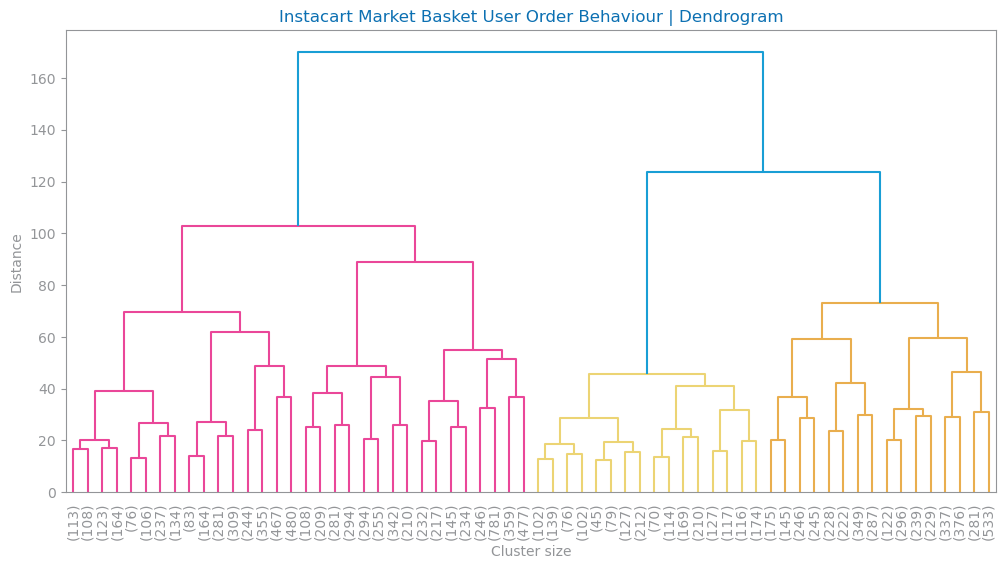

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Generate the linkage matrix
Z = linkage(reorder_numeric_features_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=5, leaf_rotation=90., leaf_font_size=10.)
plt.title(f'{file_tag} User Order Behaviour | Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()


# User Order kmeans clustering

## User Order Elbow Method Studies

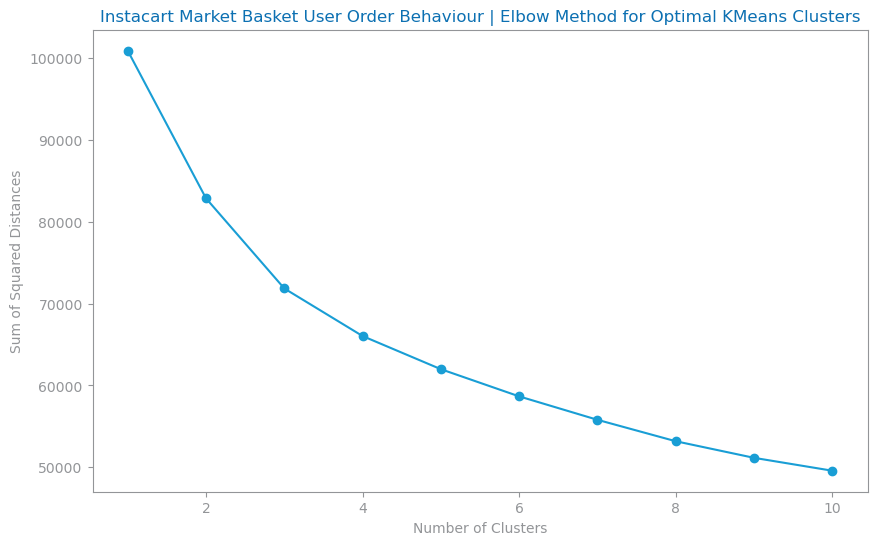

In [12]:
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

# Define the range of clusters to evaluate
range_n_clusters = list(range(1, 11))

# Initialize an empty list to store the sum of squared distances
ssd = []

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reorder_numeric_features_scaled)
    ssd.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, ssd, marker='o')
plt.title(f'{file_tag} User Order Behaviour | Elbow Method for Optimal KMeans Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()

# User Order Agglomerative

## User Order Sillouette for Agglomerative

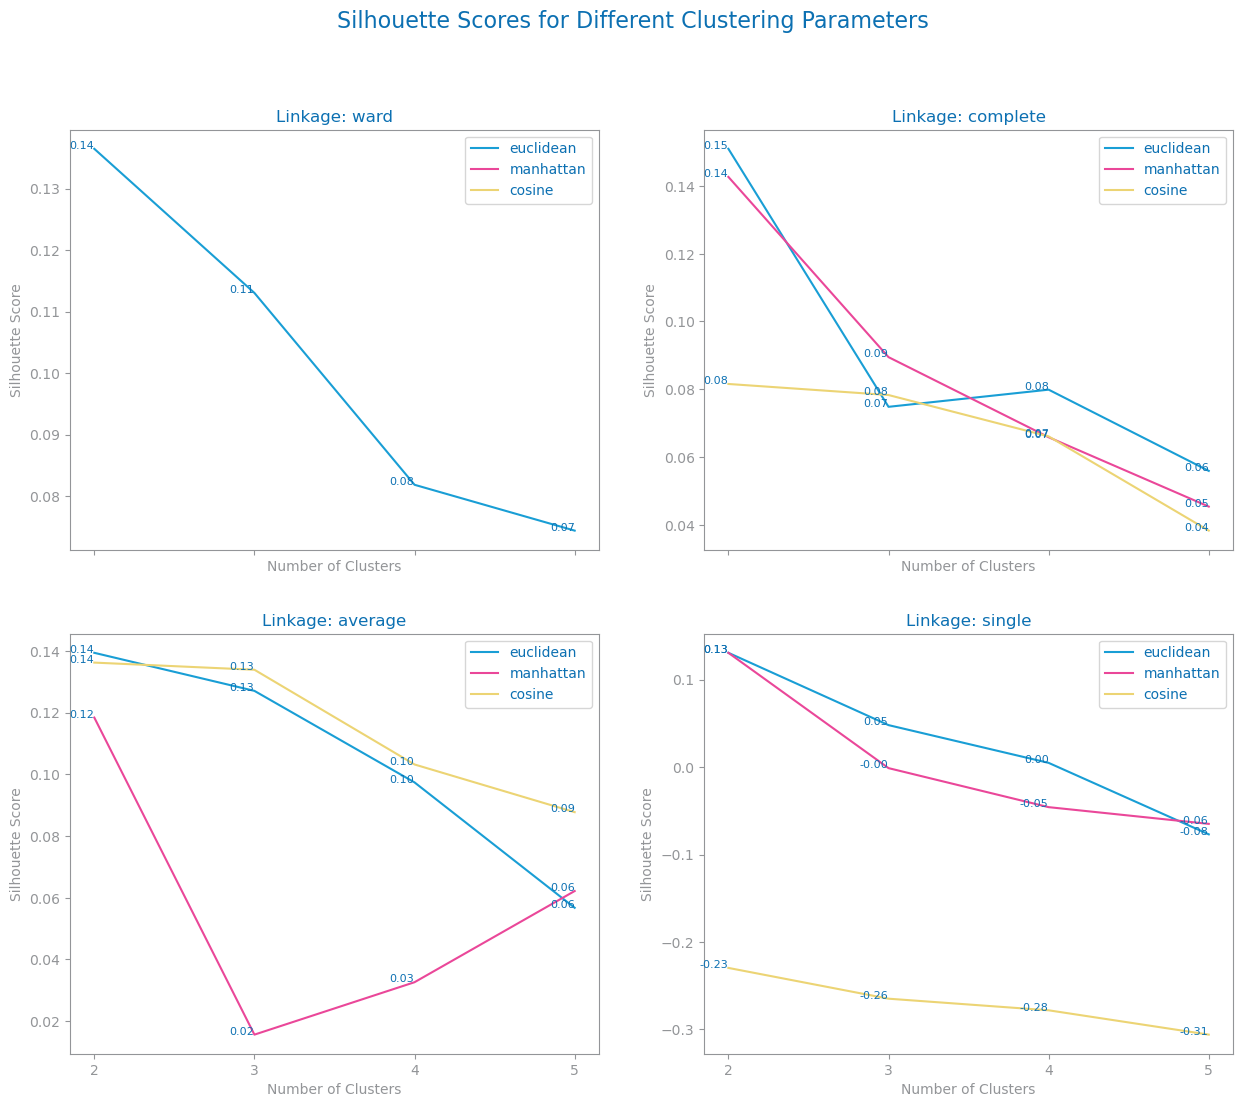

In [13]:
evaluate_agglomerative_clustering(reorder_numeric_features_scaled, n_clusters_list=[2, 3, 4, 5], scale='no')

## User Order Kmeans model

In [14]:
# Clustering
reorder_kmeans = KMeans(n_clusters=3, random_state=42)
reorder_y_pred_kmeans = reorder_kmeans.fit_predict(reorder_numeric_features_scaled)

# User Order agglomerative clustering

## User Order Agglomerative Model

In [37]:
reorder_agglo = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='average' )
reorder_y_pred_agglo = reorder_agglo.fit_predict(reorder_numeric_features_scaled)

## User Order Evaluation

In [38]:

from sklearn.metrics import silhouette_score, adjusted_rand_score


# Intrinsic Evaluation
silhouette_kmeans = silhouette_score(reorder_numeric_features_scaled, reorder_y_pred_kmeans)
silhouette_agglo = silhouette_score(reorder_numeric_features_scaled, reorder_y_pred_agglo)

print(f'Silhouette Score for KMeans: {silhouette_kmeans}')
print(f'Silhouette Score for Agglomerative Clustering: {silhouette_agglo}')



Silhouette Score for KMeans: 0.16569725805201488
Silhouette Score for Agglomerative Clustering: 0.12707876037486368


## User Order Cluster Labeling

In [39]:
# Add cluster labels to the dataframe
users_df['kmeans_cluster'] = reorder_y_pred_kmeans
users_df['agglo_cluster'] = reorder_y_pred_agglo

# Display the dataframe with the new cluster labels
users_df.head()

,user_id,total_orders,mean_num_products,mean_lag_between_orders,mean_reorder_rate,mean_weekend_order,mean_order_dow,median_order_hour,kmeans_cluster,agglo_cluster
45500,55670,7,12.000000,12.500000,0.458333,0.500000,4.500000,19.0,2,2
30292,37052,28,19.250000,10.119048,0.720238,0.583333,4.089286,10.0,0,0
163471,200033,9,14.365854,14.902439,0.439024,0.268293,2.951220,10.0,2,1
118987,145447,9,8.000000,2.000000,0.625000,0.000000,3.000000,11.0,0,1
30077,36785,28,9.480000,21.600000,0.640000,0.400000,3.920000,14.0,2,2


### User Order Cluster Counts

In [40]:
# Group by kmeans_cluster and count the number of user IDs
kmeans_cluster_counts = users_df.groupby('kmeans_cluster').size()

# Group by agglo_cluster and count the number of user IDs
agglo_cluster_counts = users_df.groupby('agglo_cluster').size()

print("KMeans Cluster Counts:")
print(kmeans_cluster_counts)

print("\nAgglomerative Clustering Counts:")
print(agglo_cluster_counts)

KMeans Cluster Counts:
kmeans_cluster
0    4186
1    6394
2    3837
dtype: int64

Agglomerative Clustering Counts:
agglo_cluster
0    3491
1    7863
2    3063
dtype: int64


In [41]:
agglo_weird_cluster = users_df[users_df['agglo_cluster']==3]

agglo_weird_cluster

,user_id,total_orders,mean_num_products,mean_lag_between_orders,mean_reorder_rate,mean_weekend_order,mean_order_dow,median_order_hour,kmeans_cluster,agglo_cluster


### User Order cluster boxplots

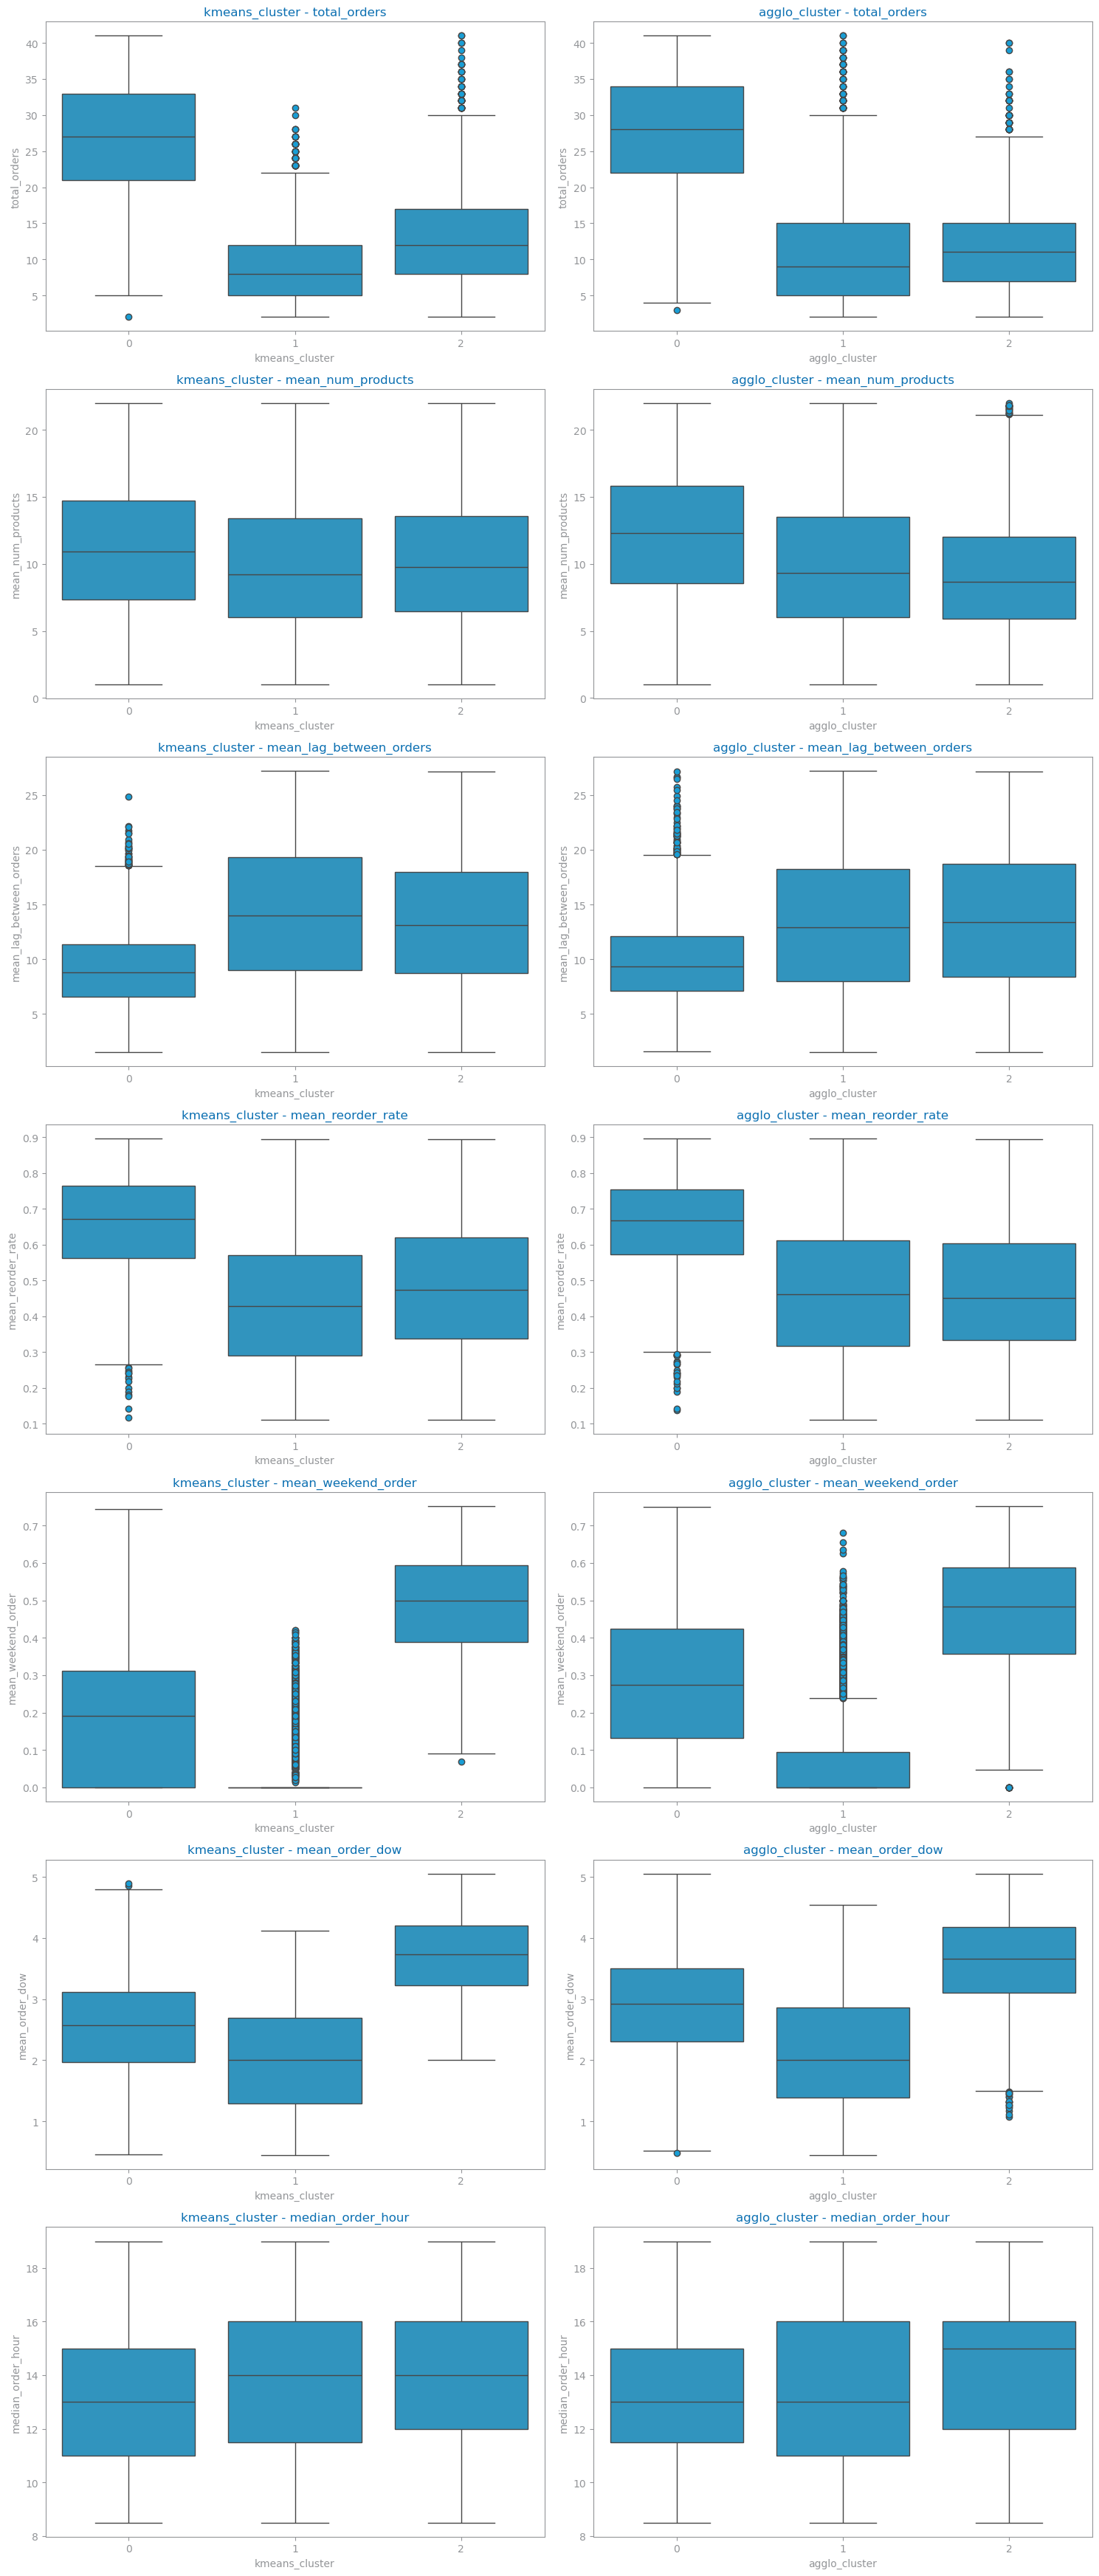

In [42]:

# Example usage
features = numeric_vars


cluster_labels = ['kmeans_cluster', 'agglo_cluster']
plot_cluster_boxplots(users_df, features, cluster_labels)

## User Order PCA visualization

In [43]:
from sklearn.decomposition import PCA

# Visualization
pca_reorder = PCA(n_components=6)
numeric_features_pca = pca_reorder.fit_transform(reorder_numeric_features_scaled)

pca_reorder_df = pd.DataFrame(numeric_features_pca, columns=[f'PC{i+1}' for i in range(numeric_features_pca.shape[1])])
pca_reorder_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,1.168388,2.128075,-0.268754,1.734183,-0.036160,-0.634375
1,2.860859,-0.320529,1.952287,-0.577319,-0.276873,-0.250090
2,-0.116734,0.568511,1.256614,-1.021922,-0.401011,-0.334020
3,0.036361,-0.898412,-0.887317,-0.951403,-1.056434,-1.385511
4,1.515160,0.582948,0.418071,-0.086212,1.603483,0.929140


## User Order pca explained variance ratio

In [44]:
# Fit the PCA model
pca_reorder.fit(reorder_numeric_features_scaled)

# Explained variance ratio
explained_variance_reorder = pca_reorder.explained_variance_ratio_
print(f'Explained variance ratio: {explained_variance_reorder}')


Explained variance ratio: [0.25669909 0.21066935 0.14616326 0.14127318 0.1248276  0.07429707]


## User Order pca plot

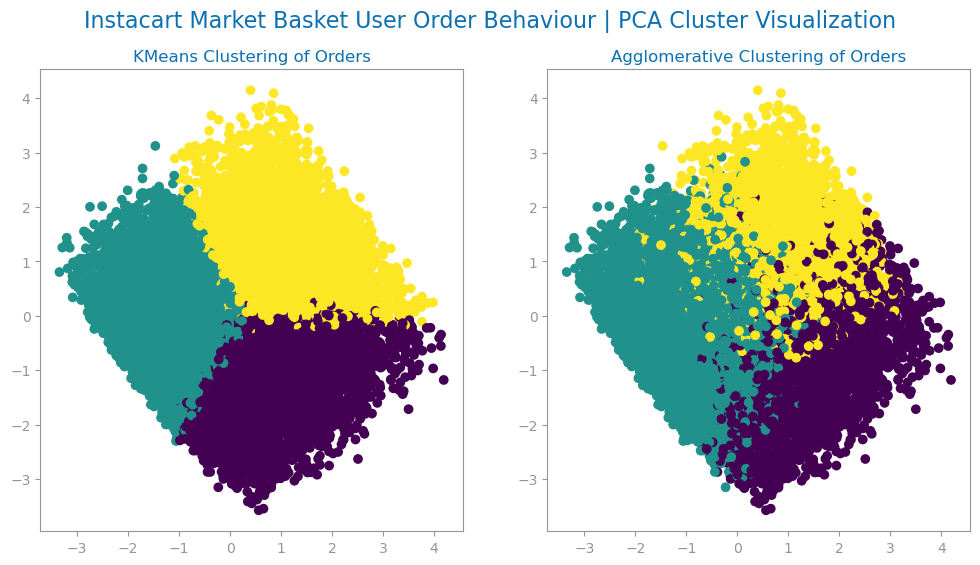

In [45]:

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(numeric_features_pca[:, 0], numeric_features_pca[:, 1], c=reorder_y_pred_kmeans)
plt.title('KMeans Clustering of Orders')

plt.subplot(122)
plt.scatter(numeric_features_pca[:, 0], numeric_features_pca[:, 1], c=reorder_y_pred_agglo)
plt.title('Agglomerative Clustering of Orders')


plt.suptitle(f"{file_tag} User Order Behaviour | PCA Cluster Visualization", fontsize=16)

plt.show()

# outputs
